## Development of grid splitting of image for the ZOGY image splitting

In [1]:
%matplotlib notebook
from lsst.geom import Box2I, Point2I, Extent2I
from lsst.afw.image import Image
import numpy as np
import matplotlib.pyplot as plt
from lsst.pipe.base import Struct
from matplotlib.widgets import Slider

In [2]:
# Create a box from 2 points
p1 = Point2I(10,10)
p2 = Point2I(5,5)
a = Box2I(p1, p2)

In [3]:
D = Image(a, dtype=np.float64)
b = a.erodedBy(2)
b.shift(Extent2I(1,0))

In [4]:
# Create 4 boxes that cover the edge, they overlap along 1 pix wide lines
def getEdgeBoxes(innerBox, outerBox):
    """Create a tuple of 4 boxes that create a edge around innerBox to fill outerBox.
    
    Parameters
    ----------
    innerBox : `lsst.geom.Box2I`
        The inner box.
    outerBox : `lsst.geom.Box2I`
        The outer box. It must be at least 1 pixel larger in each direction than the inner box.

    Returns
    -------
    resultName : `tuple` of 4 boxes covering the edge around innerBox

    Notes
    -----
    The edge boxes overlap along 1 pixel wide lines.

    Raises
    ------
    ValueError : If outerBox is not larger than innerBox.
    """
    innerBox = innerBox.dilatedBy(1)
    if not outerBox.contains(innerBox):
        raise ValueError("Outerbox must be larger by at least 1 pixel in all directions")
    p1 = Point2I(outerBox.minX, innerBox.minY)
    p2 = Point2I(innerBox.maxX, outerBox.minY)
    p3 = Point2I(outerBox.maxX, innerBox.maxY)
    p4 = Point2I(innerBox.minX, outerBox.maxY)

    boxes = (Box2I(p1, p2, invert=True), 
             Box2I(p2, p3, invert=True),
             Box2I(p3, p4, invert=True),
             Box2I(p4, p1, invert=True))
    
    return boxes

In [5]:
# Create 8 boxes that cover the edge, they do not overlap
# To save the random number generator, check whether boxes are included in the image overlap
def getEdgeBoxesSmaller(innerBox, outerBox):
    """Create a list of 8 boxes that create an edge around innerBox to fill outerBox
    
    Parameters
    ----------
    innerBox : `lsst.geom.Box2I`
        The inner box.
    outerBox : `lsst.geom.Box2I`
        The outer box. It must be at least 1 pixel larger in each direction than the inner box.

    Returns
    -------
    resultName : `list` of 8 boxes covering the edge around innerBox

    Notes
    -----
    The edge boxes do not overlap. The edge is covered counter clockwise 
    starting from lower left corner.

    Raises
    ------
    ValueError : If outerBox is not larger than innerBox.
    """
    innerBox = innerBox.dilatedBy(1)
    if not outerBox.contains(innerBox):
        raise ValueError("OuterBox must be larger by at least 1 pixel in all directions")
    
    # ccw sequence of corners
    o1, o2, o3, o4 = outerBox.getCorners()
    i1, i2, i3, i4 = innerBox.getCorners()
    p1 = Point2I(outerBox.minX, innerBox.minY)
    p2 = Point2I(innerBox.maxX, outerBox.minY)
    p3 = Point2I(outerBox.maxX, innerBox.maxY)
    p4 = Point2I(innerBox.minX, outerBox.maxY)
    
    # The 8 edge boxes ccw starting from lower left
    pointPairs = ((o1, i1), (i1+Extent2I(1,0), p2+Extent2I(-1,0)), (o2, i2),
                  (i2+Extent2I(0,1), p3+Extent2I(0,-1)), (o3, i3), (i3+Extent2I(-1,0), p4+Extent2I(1,0)),
                  (o4, i4), (i4+Extent2I(0,-1), p1+Extent2I(0,1)))
    return [Box2I(x, y, invert=True) for (x, y) in pointPairs]

In [6]:
eboxes = getEdgeBoxesSmaller(b, a)

In [7]:
eboxes

[Box2I(minimum=Point2I(5, 5), dimensions=Extent2I(3, 2)),
 Box2I(minimum=Point2I(8, 5), dimensions=Extent2I(2, 2)),
 Box2I(minimum=Point2I(10, 5), dimensions=Extent2I(1, 2)),
 Box2I(minimum=Point2I(10, 7), dimensions=Extent2I(1, 2)),
 Box2I(minimum=Point2I(10, 9), dimensions=Extent2I(1, 2)),
 Box2I(minimum=Point2I(8, 9), dimensions=Extent2I(2, 2)),
 Box2I(minimum=Point2I(5, 9), dimensions=Extent2I(3, 2)),
 Box2I(minimum=Point2I(5, 7), dimensions=Extent2I(3, 2))]

In [8]:
# To fill the edges with data or random noise, use a loop like this
for bb in eboxes:
    A = D[bb].array
    A[...] = np.random.normal(size=A.shape)

<IPython.core.display.Javascript object>


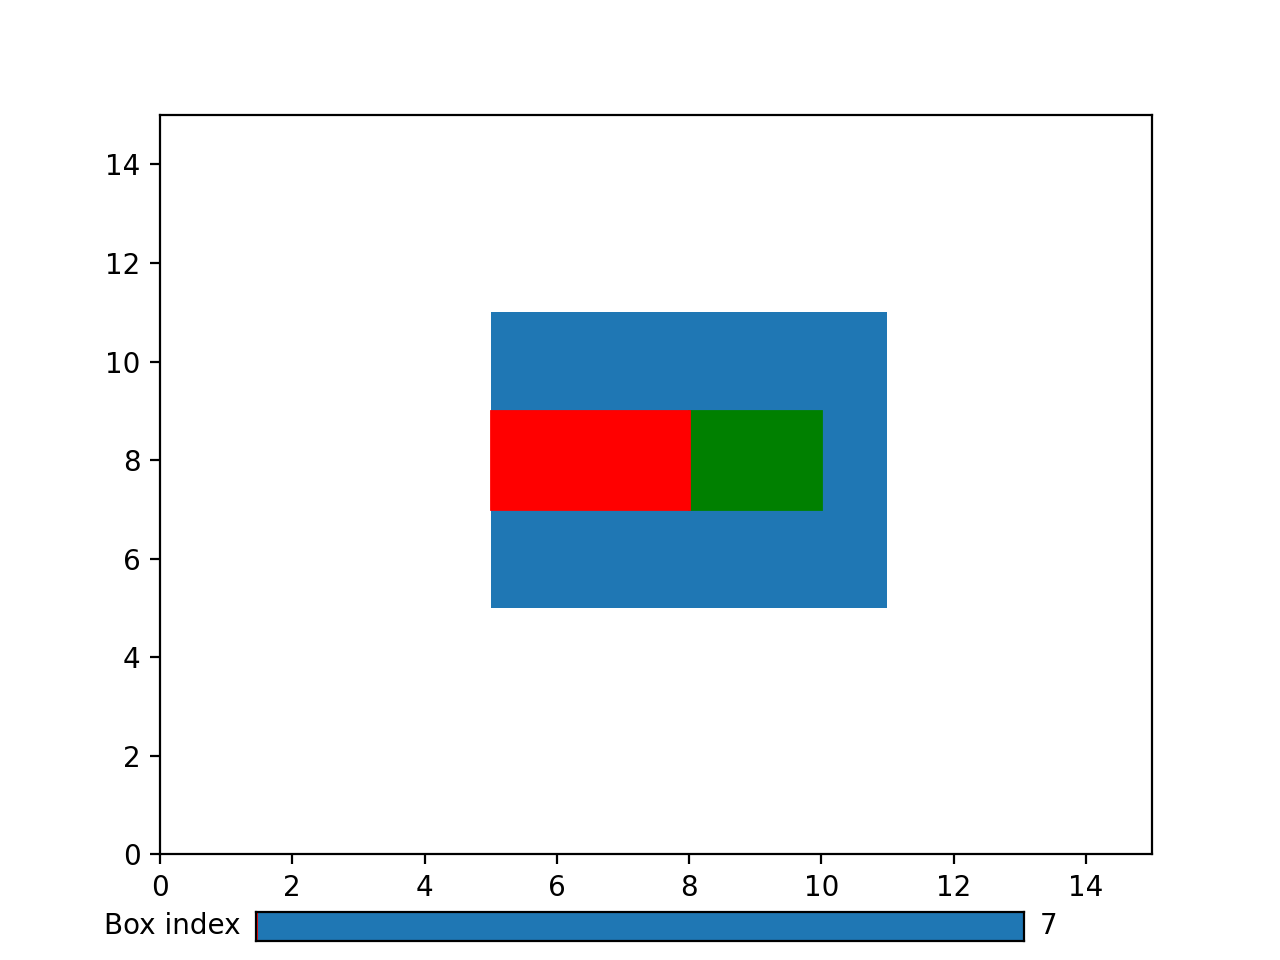

In [9]:
# Check the boxes

class BoxPlot:
    """Interactive plot"""
    def __init__(self, eboxes):
        self.eboxes = eboxes
        
    def plot(self):
        bb = self.eboxes[0]

        fig, ax = plt.subplots()
        ax.add_patch(plt.Rectangle(tuple(a.getMin()),a.getWidth(), a.getHeight()))
        ax.add_patch(plt.Rectangle(tuple(b.getMin()),b.getWidth(), b.getHeight(), color = 'g'))
        self.edgeboxP = plt.Rectangle(tuple(bb.getMin()),bb.getWidth(), bb.getHeight(), color = 'r')
        ax.add_patch(self.edgeboxP)
        ax.set_xlim(0, 15)
        ax.set_ylim(0, 15)
        axslider = plt.axes([0.2, 0.02, 0.6, 0.03])
        self.slider = Slider(axslider,'Box index',0,7,valinit=0,valstep=1)
        self.ax = ax
        self.slider.on_changed(self.update)
    
    def update(self, val):
        self.edgeboxP.remove()
        bb = self.eboxes[val]
        self.edgeboxP = plt.Rectangle(tuple(bb.getMin()),bb.getWidth(), bb.getHeight(), color = 'r')
        self.ax.add_patch(self.edgeboxP)
    
bp = BoxPlot(eboxes)
bp.plot()

In [10]:
def generateGrid(imageBox, minEdgeDims, innerBoxDims, minTotalDims=None, powerOfTwo=False):
    """Generate a splitting grid for an image.
    
    The inner boxes cover the input image without overlap, the edges around the inner boxes do overlap
    and go beyond the image at the image edges.
    
    Parameters
    ----------
    imageBox : `lsst.geom.Box2I`
        Bounding box of the exposure to split.
    minEdgeDims : `lsst.geom.Extent2I`
        Minimum edge width in (x,y) directions each side.
    innerBoxDims : `lsst.geom.Extent2I`
        Minimum requested inner box dimensions (x,y). The actual size can be larger due to rounding.
    minTotalDims: `lsst.geom.Extent2I`, optional
        If provided, minimum total outer dimensions (x,y). The edge will be increased until satisfied.
    powerOfTwo : `bool`, optional
        If True, the total dimensions should be rounded up to a power of 2 by increasing the edge size.

    Notes
    -----
    Inner box dimensions are chosen to be as uniform as they can, remainder pixels at the edge of the 
    input will be appended to the last column/row boxes.

    Returns
    -------
    boxList : `list` of `lsst.pipe.base.Struct`
      ``innerBox``, ``outerBox`` : `lsst.geom.Box2I`, inner boxes and overlapping edges around them.
            
    """
    powerOf2 = np.array([16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192])
    doubleEdgeDims = minEdgeDims * 2
    xsize, ysize = imageBox.getDimensions()
    nX = xsize // innerBoxDims.x  # Round down
    if nX > 0:
        inXsize = xsize // nX  # Round down
    else:
        inXsize = xsize
        nX = 1
    xCorners = np.zeros(nX + 1)
    xCorners[:-1] = np.arange(nX)*inXsize + imageBox.minX 
    xCorners[-1] = imageBox.endX

    nY = ysize // innerBoxDims.y  # Round down
    if nY > 0:
        inYsize = ysize // nY  # Round down
    else:
        inYsize = ysize
        nY = 1
    yCorners = np.zeros(nY + 1)
    yCorners[:-1] = np.arange(nY)*inYsize + imageBox.minY 
    yCorners[-1] = imageBox.endY
    
    boxes = []
    
    for i_y in range(nY):
        for i_x in range(nX):
            innerBox = Box2I(Point2I(xCorners[i_x], yCorners[i_y]), 
                             Point2I(xCorners[i_x + 1] - 1, yCorners[i_y + 1] - 1))

            p2x = innerBox.width + doubleEdgeDims.x
            if minTotalDims is not None and p2x<minTotalDims.width:
                p2x = minTotalDims.width
            if powerOfTwo:
                i2x = np.searchsorted(powerOf2, p2x, side='left')
                if i2x < len(powerOf2):
                    p2x = powerOf2[i2x]
            totalXedge = p2x - innerBox.width
            
            p2y = innerBox.height + doubleEdgeDims.y
            if minTotalDims is not None and p2y<minTotalDims.height:
                p2y = minTotalDims.height
            if powerOfTwo:
                i2y = np.searchsorted(powerOf2, p2y, side='left')
                if i2y < len(powerOf2):
                    p2y = powerOf2[i2y]             
            totalYedge = p2y - innerBox.height
            outerBox = Box2I(Point2I(innerBox.minX - totalXedge//2, innerBox.minY - totalYedge//2),
                             Extent2I(p2x, p2y))
            boxes.append(Struct(innerBox=innerBox, outerBox=outerBox))
    return boxes

In [11]:
A = Box2I(Point2I(0,0), Extent2I(100, 100))

In [12]:
b1 = generateGrid(A, Extent2I(5, 5), Extent2I(30, 30), powerOfTwo=True)

In [13]:
b1

[Struct(innerBox=(minimum=(0, 0), maximum=(32, 32)); outerBox=(minimum=(-15, -15), maximum=(48, 48))),
 Struct(innerBox=(minimum=(33, 0), maximum=(65, 32)); outerBox=(minimum=(18, -15), maximum=(81, 48))),
 Struct(innerBox=(minimum=(66, 0), maximum=(99, 32)); outerBox=(minimum=(51, -15), maximum=(114, 48))),
 Struct(innerBox=(minimum=(0, 33), maximum=(32, 65)); outerBox=(minimum=(-15, 18), maximum=(48, 81))),
 Struct(innerBox=(minimum=(33, 33), maximum=(65, 65)); outerBox=(minimum=(18, 18), maximum=(81, 81))),
 Struct(innerBox=(minimum=(66, 33), maximum=(99, 65)); outerBox=(minimum=(51, 18), maximum=(114, 81))),
 Struct(innerBox=(minimum=(0, 66), maximum=(32, 99)); outerBox=(minimum=(-15, 51), maximum=(48, 114))),
 Struct(innerBox=(minimum=(33, 66), maximum=(65, 99)); outerBox=(minimum=(18, 51), maximum=(81, 114))),
 Struct(innerBox=(minimum=(66, 66), maximum=(99, 99)); outerBox=(minimum=(51, 51), maximum=(114, 114)))]

In [14]:
for x in b1: print(x.innerBox.getDimensions(),x.outerBox.getDimensions())

(33, 33) (64, 64)
(33, 33) (64, 64)
(34, 33) (64, 64)
(33, 33) (64, 64)
(33, 33) (64, 64)
(34, 33) (64, 64)
(33, 34) (64, 64)
(33, 34) (64, 64)
(34, 34) (64, 64)


<IPython.core.display.Javascript object>


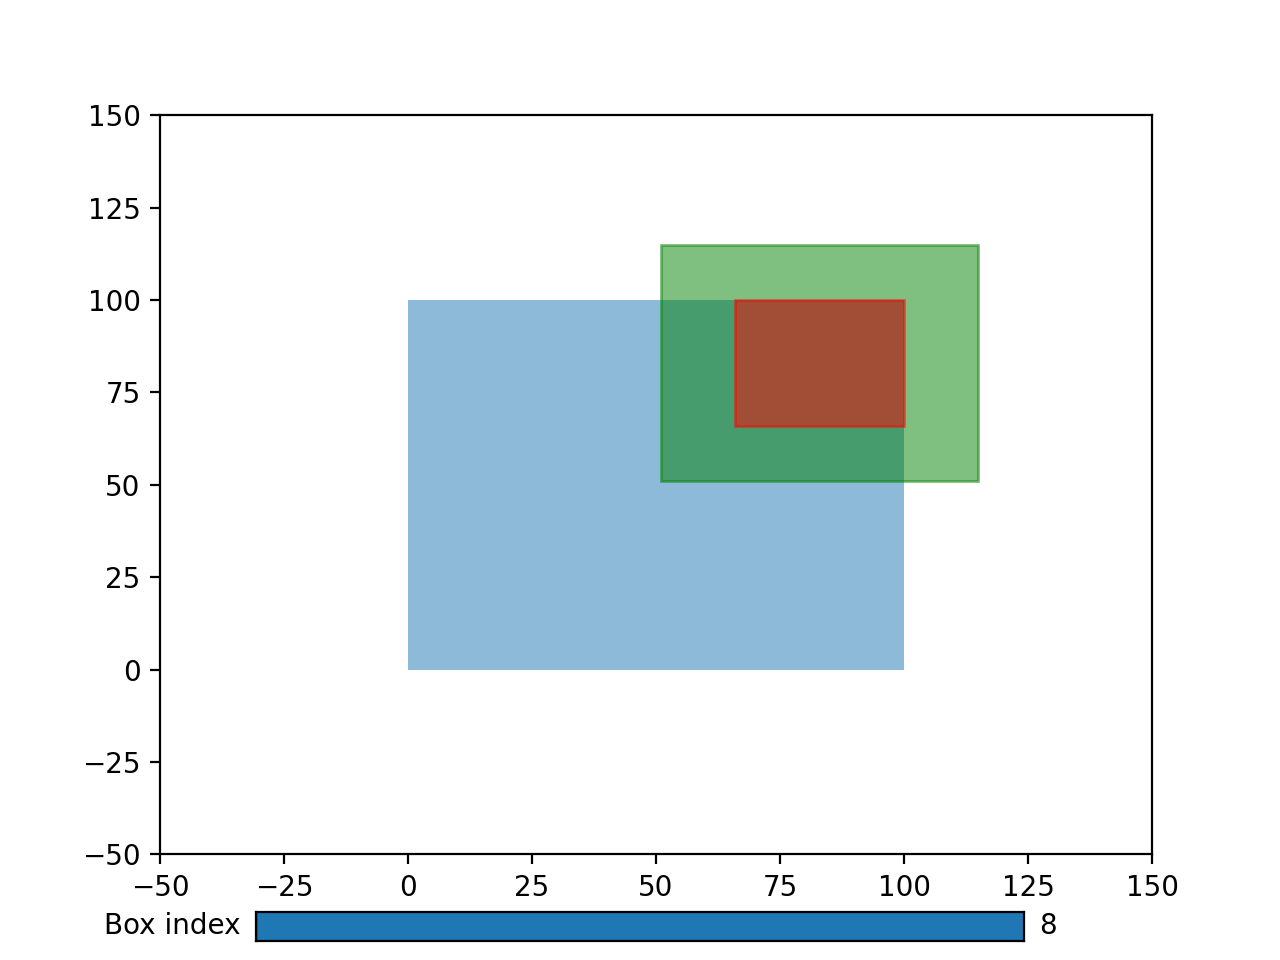

In [15]:
class GridPlot:
    """Interactive plot"""
    def __init__(self, b1):
        self.b1 = b1   
        self.val = 0
        # Check the boxes
        ib = b1[0].innerBox
        ob = b1[0].outerBox

        fig, ax = plt.subplots()
        ax.add_patch(plt.Rectangle(tuple(A.getMin()),A.getWidth(), A.getHeight(), alpha=0.5))
        self.innerboxP = plt.Rectangle(tuple(ob.getMin()),ob.getWidth(), ob.getHeight(), color = 'g', alpha=0.5)
        self.edgeboxP = plt.Rectangle(tuple(ib.getMin()),ib.getWidth(), ib.getHeight(), color = 'r', alpha=0.5)
        ax.add_patch(self.innerboxP)
        ax.add_patch(self.edgeboxP)
        ax.set_xlim(-50, 150)
        ax.set_ylim(-50, 150)
        axslider = plt.axes([0.2, 0.02, 0.6, 0.03])
        self.slider = Slider(axslider,'Box index',0,len(self.b1)-1,valinit=0,valstep=1)
        self.ax = ax
        self.slider.on_changed(self.update)

    def update(self, val):
        self.val = val
        self.innerboxP.remove()
        self.edgeboxP.remove()
        ib = self.b1[val].innerBox
        ob = self.b1[val].outerBox
        self.innerboxP = plt.Rectangle(tuple(ob.getMin()),ob.getWidth(), ob.getHeight(), color = 'g', alpha=0.5)
        self.edgeboxP = plt.Rectangle(tuple(ib.getMin()),ib.getWidth(), ib.getHeight(), color = 'r', alpha=0.5)
        self.ax.add_patch(self.innerboxP)
        self.ax.add_patch(self.edgeboxP)

gp = GridPlot(b1)

In [16]:
# Check the edgebox components of the selected grid element
ib = b1[gp.val].innerBox
ob = b1[gp.val].outerBox
eboxes = getEdgeBoxesSmaller(ib, ob)

Now we can use the small edge boxes to initialize only the parts that are not fully inside the image

In [17]:
# Edge boxes that is fully contained by A will contain image data, no initialization is needed
# Otherwise we need to initialize with random model noise
for bb in eboxes:
    print(A.contains(bb))

False
False
False
True
True
True
False
False
